In [1]:
import anndata
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import os
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from utils import load_annotations
from torch.utils.data import Dataset, DataLoader
import argparse
from sklearn.linear_model import LogisticRegression
import time 

from datasets import RNASeqData
from models import pmVAEModel
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder

import os

/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
rand_seed=0

In [4]:
data  = anndata.read('/projects/leelab/data/single-cell/mcfarland_2020_Idasanutlin/preprocessed/adata_top_2000_genes_tc.h5ad')

/homes/gws/aspiro17/miniconda3/envs/fresh_anndata/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
data = data[data.obs['condition'] == 'Idasanutlin'].copy() 

In [8]:
symbols = data.var_names

In [9]:
train_data, test_data = train_test_split(data,
                                        test_size=0.25,
                                        shuffle=True,
                                        random_state=rand_seed)
tr_data, val_data = train_test_split(train_data,
                                    test_size=0.25,
                                    shuffle=True,
                                    random_state=rand_seed)

tr_ds = RNASeqData(np.array(tr_data.X))
val_ds = RNASeqData(np.array(val_data.X))

In [10]:
membership_mask = load_annotations('data/c2.cp.reactome.v7.4.symbols.gmt',
                                    symbols,
                                    min_genes=13
                                ).astype(bool).T

In [11]:
no_cond_checkpoint_path = 'saved_models/no_cond_mcfarland.pkl.best_loss'

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [13]:
no_cond_model = pmVAEModel(membership_mask.values,
                                [12],
                                1,
                                beta=1e-05,
                                terms=membership_mask.index,
                                add_auxiliary_module=True
                            )

In [14]:
no_cond_model.load_checkpoint(no_cond_checkpoint_path)

In [15]:
no_cond_model.set_gpu(False)

In [16]:
ground_truth = torch.tensor(np.array(data.X)).float()
outs = no_cond_model.model(ground_truth)

input_data = outs.z

In [17]:
input_data.shape

torch.Size([3097, 171])

In [18]:
outs.z.shape

torch.Size([3097, 171])

In [19]:
path_values = outs.z.detach().numpy()

In [20]:
cell_line_vals = list(data.obs['cell_line'].values)
len(cell_line_vals)

3097

In [57]:
unique_cell_lines = list(set(list(data.obs['cell_line'].values)))
unique_cell_lines

['LS1034_LARGE_INTESTINE',
 'SH10TC_STOMACH',
 'NCIH226_LUNG',
 'BICR31_UPPER_AERODIGESTIVE_TRACT',
 'IALM_LUNG',
 'SQ1_LUNG',
 'TEN_ENDOMETRIUM',
 'SKMEL3_SKIN',
 'BICR6_UPPER_AERODIGESTIVE_TRACT',
 'CAOV3_OVARY',
 'LNCAPCLONEFGC_PROSTATE',
 'RERFLCAD1_LUNG',
 'COLO680N_OESOPHAGUS',
 'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM',
 'SKMEL2_SKIN',
 'RCC10RGB_KIDNEY',
 'NCIH2347_LUNG',
 'COV434_OVARY',
 'DKMG_CENTRAL_NERVOUS_SYSTEM',
 'UMUC1_URINARY_TRACT',
 'SNU1079_BILIARY_TRACT',
 'BT549_BREAST',
 'RCM1_LARGE_INTESTINE',
 'BT474_BREAST']

## analyze if pathways separate by cell line

In [97]:
# do this in a function! 

combined_cell_lines = ['LS1034_LARGE_INTESTINE',
 'SH10TC_STOMACH',
 'NCIH226_LUNG',
 'CAOV3_OVARY',
 'COLO680N_OESOPHAGUS',
 'SKMEL2_SKIN',
 'RCC10RGB_KIDNEY',
 'DKMG_CENTRAL_NERVOUS_SYSTEM',
 'UMUC1_URINARY_TRACT',
 'BT474_BREAST']

def pathway_density_plot(path_name):
    idx = list(membership_mask.index).index(path_name)
    vals = path_values[:,idx]
    res = {}
    for line in combined_cell_lines: 
        res[line] = []

    for line in combined_cell_lines: 
        for i in range(len(cell_line_vals)): 
            if cell_line_vals[i] == line: # this entry is this cell line
                res[line].append(vals[i])
    
    g = sb.displot(data=res, kind="kde", palette='colorblind').set(xlim=(-4,5))     
    g.savefig('new_for_revision/new_figs/Mcfarland_separate_' + path_name + '_.pdf', bbox_inches='tight')

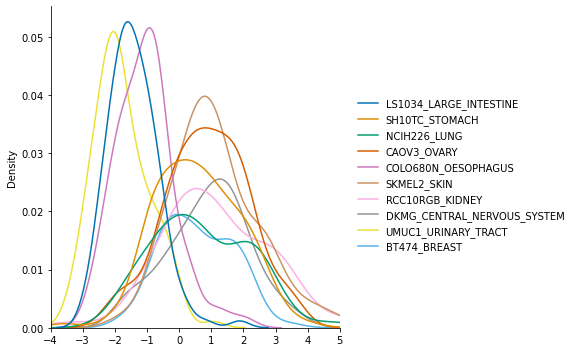

In [98]:
pathway_density_plot('REACTOME_INNATE_IMMUNE_SYSTEM')